In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import r2_score, mean_squared_error
import theano.tensor as tt
from theano import shared
import pandas as pd
from pandas.plotting import scatter_matrix
from tqdm import tqdm
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [3]:
tqdm.monitor_interval = 0

In [4]:
class PyMCModel:
    def __init__(self, model, X, y, model_name='None'):
        self.model = model(X, y)
        self.model.name = model_name
        
    def fit(self, n_samples=2000):
        with self.model:
            self.trace_ = pm.sample(n_samples)
    
    def fit_ADVI(self, n_samples=2000, n_iter=100000, inference='advi'):
        with self.model:
            approx_fit = pm.fit(n=n_iter, method=inference)
            self.trace_ = approx_fit.sample(draws=n_samples)
    
    def show_model(self):
        return pm.model_to_graphviz(self.model)
    
    def predict(self, X, w_index=[]):
        ws = self.trace_['w'].T
        if len(w_index)>0:
            ws = ws[w_index]
        return X.dot(ws) + self.trace_['alpha']
    
    def evaluate_fit(self, show_feats):
        return pm.traceplot(self.trace_, varnames=show_feats)
    
    def show_forest(self, show_feats, feat_labels=None):
        g = pm.forestplot(self.trace_, varnames=show_feats,
                             ylabels=feat_labels)
        f = pl.gcf()
        ax = f.get_axes()[1]
        ax.grid(axis='y')
        return g
    
    def plot_model_fits(self, y_obs, title=None, ax=None):
        y_model = self.trace_.get_values('mu')
        y_model_mean = np.mean(y_model, axis=0)
        y_model_hpd = pm.hpd(y_model)
        ppc_y = pm.sample_ppc(self.trace_, model=self.model)['y']
        ppc_y_mean = ppc_y.mean(axis=0)
        hpd = pm.hpd(ppc_y)
        try:
            rmse = np.sqrt(mean_squared_error(y_obs, y_model_mean))
        except ValueError:
            mask = np.isnan(y_obs)
            y_model_mean = np.ma.array(data=y_model_mean, mask=mask).compressed()
            y_obs = np.ma.array(data=y_obs, mask=mask).compressed()
        finally:    
            r2 = r2_score(y_obs, y_model_mean)
            rmse = np.sqrt(mean_squared_error(y_obs, y_model_mean))
        if ax is None:
            _, ax = pl.subplots(figsize=(10, 10),)# nrows=2)
        ax.set_title('Model Fit')
        ax.set_xlabel('modeled')
        ax.set_ylabel('observed')
        ax.scatter(y_model_mean, y_obs, color='k', alpha=0.5,
                     label='$log_{10}(chl)$, $r^2=%.2f$, rmse=%.2f' %(r2, rmse));
        ax.plot([-1.5, 1.5], [-1.5, 1.5], 'k--', label='1:1')
        ax.axis('equal')
        ax.legend(loc='best')
        """ix = np.argsort(y_obs.ravel())
        xi = np.arange(y_obs.size)
        ax[1].set_title('Posterior Predictive Checks')
        ax[1].set_xlabel('obs #')
        ax[1].set_ylabel('$log_{10}(chl)$')
        ax[1].plot(y_obs.ravel()[ix], ls='', marker='.', color='k', label='Obs')
        ax[1].plot(ppy_y_mean[ix], ls='', color='r', marker='o', markersize=10,
                   alpha=0.7, label='PPC mean')
        ax[1].fill_between(xi, hpd[ix, 0], hpd[ix, 1], color='orange',
                           alpha=0.3, label='PPC 95% Cred. Int.');
        ax[1].legend(loc='best');"""
        f = pl.gcf()
        f.suptitle(title, y=1.01);
        f.tight_layout()
        return ax

In [5]:
def hs_regression(X, y_obs, ylabel='y', tau_0=None, regularized=False, **kwargs):
    """See Piironen & Vehtari, 2017 (DOI: 10.1214/17-EJS1337SI)"""
    if tau_0 is None:
        M = X.shape[1]
        m0 = M/2
        N = X.shape[0]
        tau_0 = m0 / ((M - m0) * np.sqrt(N))
    if regularized:
        slab_scale = kwargs.pop('slab_scale', 3)
        slab_scale_sq = slab_scale ** 2
        slab_df = kwargs.pop('slab_df', 8)
        half_slab_df = slab_df / 2
        with pm.Model() as mhsr:
            tau = pm.HalfCauchy('tau', tau_0)
            c_sq = pm.InverseGamma('c_sq', alpha=half_slab_df,
                                   beta=half_slab_df * slab_scale_sq)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            lamb_m_bar = tt.sqrt(c_sq) * lamb_m / (tt.sqrt(c_sq + 
                                                           tt.pow(tau, 2) *
                                                           tt.pow(lamb_m, 2)
                                                          )
                                                  )
            w = pm.Normal('w', mu=0, sd=tau*lamb_m_bar, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhsr
    else:
        with pm.Model() as mhs:
            tau = pm.HalfCauchy('tau', tau_0)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            w = pm.Normal('w', mu=0, sd = tau*lamb_m, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhs

    
def lasso_regression(X, y_obs, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=0, b=sd_beta)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


def lasso_regr_impute_y(X, y_obs, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlass_y_na:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=0, b=sd_beta)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        mu_y_obs = pm.Normal('mu_y_obs', 0.5, 1)
        sigma_y_obs = pm.HalfCauchy('sigma_y_obs', 1)
        y_obs_ = pm.Normal('y_obs', mu_y_obs, sigma_y_obs, observed=y_obs.squeeze())
        y = pm.Normal('y', mu=y_obs_, sd=sig)
    return mlass_y_na


def hier_lasso_regr(X, y_obs, add_bias=True, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        hyp_beta = pm.HalfCauchy('hyp_beta', beta=2.5)
        hyp_mu = pm.HalfCauchy('hyp_mu', mu=0, beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=hyp_mu, b=hyp_beta)
        w = pm.Laplace('w', mu=hyp_mu, b=hyp_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


def subset_significant_feature(trace, labels_list, beg_feat, alpha=0.05, vars_=None):
    if vars_ is None:
        vars_ = ['sd_beta', 'sigma', 'alpha', 'w']
    dsum = pm.summary(trace, varnames=vars_, alpha=alpha)
    lbls_list = ['w[%s]' %lbl for lbl in labels_list]
    dsum.index = vars_[:-1] + lbls_list 
    hpd_lo, hpd_hi = 100 * (alpha / 2), 100 * (1 - alpha / 2)
    if str(hpd_lo).split('.')[1] == '0':
        hpd_lo = int(hpd_lo)
    if str(hpd_hi).split('.')[1] == '0':
        hpd_hi = int(hpd_hi)
    dsum_subset = dsum[(((dsum[f'hpd_{hpd_lo}']<0)&(dsum[f'hpd_{hpd_hi}']<0))|
                    ((dsum[f'hpd_{hpd_lo}']>0) & (dsum[f'hpd_{hpd_hi}']>0))
                   )]
    pattern1 = r'w\s*\[([a-z_\sA-Z0-9]+)\]'
    return list(dsum_subset.index.str.extract(pattern1).dropna().values.flatten())


#def biome_hier_regression(X, y_obs, add_bias=True, ylabel='y'):
#    if add_bias:
#        X = np.c_[np.ones((X.shape[0],)), X]
#    with pm.Model() as mbhlasso:
#        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
#        wh = 

def Plot_Model_Fits(trace, model, title=None, ax=None):
    mu_log10chl = trace.get_values('mu')
    mu_log10chl_mean = np.median(mu_log10chl, axis=0)

    mu_hpd = pm.hpd(mu_log10chl)

    ppc_y = pm.sample_ppc(trace, model=model)['y']
    mn = ppc_y.mean(axis=0)
    hpd = pm.hpd(ppc_y)
    rmse = np.sqrt(mean_squared_error(y, mu_log10chl_mean))
    r2 = r2_score(y, mu_log10chl_mean)
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 18), nrows=2)
    ax[0].set_title('Model Fit')
    ax[0].set_xlabel('modeled')
    ax[0].set_ylabel('observed')
    ax[0].scatter(mu_log10chl_mean, y, color='k', alpha=0.5,
                 label='$log_{10}(chl)$, $r^2=%.2f$, rmse=%.2f' %(r2, rmse));
    ax[0].plot([-1.5, 1.5], [-1.5, 1.5], 'k--', label='1:1')
    ax[0].axis('equal')
    ax[0].legend(loc='best')
    ix = np.argsort(y.ravel())
    xi = np.arange(y.size)
    ax[1].set_title('Posterior Predictive Checks')
    ax[1].set_xlabel('obs #')
    ax[1].set_ylabel('$log_{10}(chl)$')
    ax[1].plot(y.ravel()[ix], ls='', marker='.', color='k', label='Obs')
    ax[1].plot(mn[ix], ls='', color='r', marker='o', markersize=10,
               alpha=0.7, label='PPC mean')
    ax[1].fill_between(xi, hpd[ix, 0], hpd[ix, 1], color='orange',
                       alpha=0.3, label='PPC 95% Cred. Int.');
    ax[1].legend(loc='best');
    f = pl.gcf()
    f.suptitle(title, y=1.01);
    f.tight_layout()
    return ax

In [6]:
ds = pd.read_pickle('./pickleJar/df_rs_6_FullSet_noInteractions.pkl')
dps = pd.read_pickle('./pickleJar/df_rs_6_FullSet_MaxInteractions.pkl')
dpcapoly_s = pd.read_pickle('./pickleJar/df_rs_6_FullSet_PCAInteractions.pkl')

In [7]:
ds.head().T

,0,1,2,3,4
Biome,Westerlies,Polar,Polar,Polar,Trades
BiomCat,3,1,1,1,2
Province,"Mediterranean Sea, Black Sea Province",Antarctic Province,Austral Polar Province,Austral Polar Province,N. Atlantic Tropical Gyral Province (Trpg)
ProvCode,MEDI,ANTA,APLR,APLR,NATR
Coastal,0,0,0,0,0
ProvCat,42,22,25,25,33
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.0645084
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866


In [8]:
feat_beg = 'sin_doy'
feat_end_ni = 'PC6_s'
feat_end_wi = 'PC5_s PC6_s'
X_s = ds.dropna().loc[:, feat_beg: feat_end_ni].values
X_s_na = ds.loc[:, feat_beg: feat_end_ni].values
lbls_X_s = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
Xp_s = dps.dropna().loc[:, feat_beg: feat_end_wi].values
lbls_Xp_s = dps.loc[:, feat_beg: feat_end_wi].columns.tolist()
Xp_s_na = dps.loc[:, feat_beg: feat_end_wi].values
Xpcap_s = dpcapoly_s.dropna().loc[:, feat_beg: feat_end_wi].values
lbls_Xpcap_s = dpcapoly_s.loc[:, feat_beg: feat_end_wi].columns.tolist()
Xpcap_s_na = dpcapoly_s.loc[:, feat_beg: feat_end_wi].values
y = ds.dropna().log10_chl
y_na = ds.log10_chl

### <u>No Interactions</u>
<br>
#### <u>1. Fitting with NaNs dropped (no imputations)</u>

In [9]:
m_lasso_ = PyMCModel(lasso_regression, X_s, y, model_name='lasso_no_imp')
m_lasso_.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:09<00:00, 1093.60draws/s]


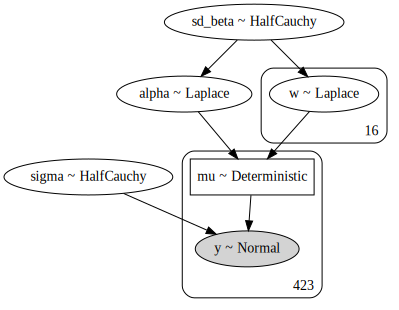

In [10]:
m_lasso_.show_model()

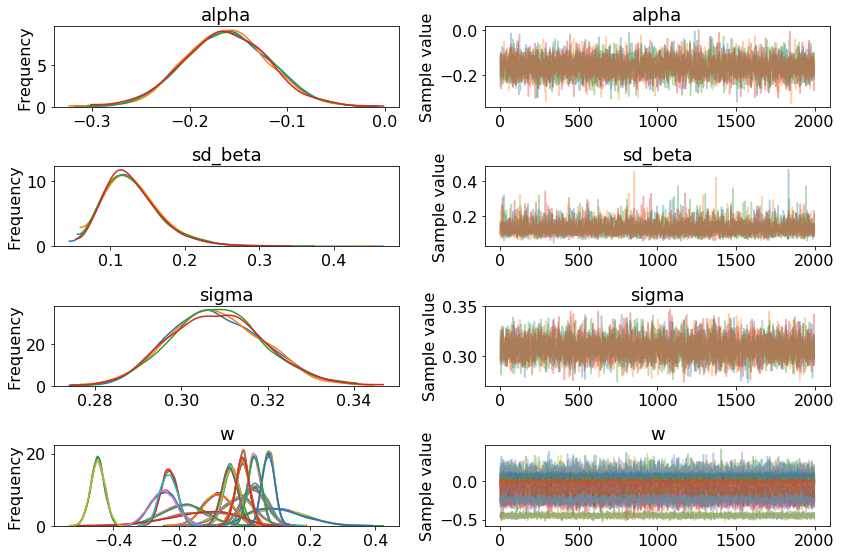

In [11]:
vars_ = ['alpha', 'sd_beta', 'sigma', 'w',]
m_lasso_.evaluate_fit(show_feats=vars_);

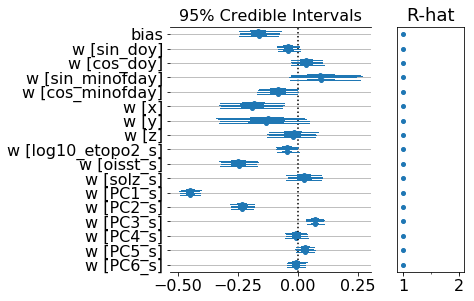

In [12]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_lasso_.show_forest(['alpha', 'w'], feat_labels=lbls_list);

100%|██████████| 2000/2000 [00:01<00:00, 1614.60it/s]


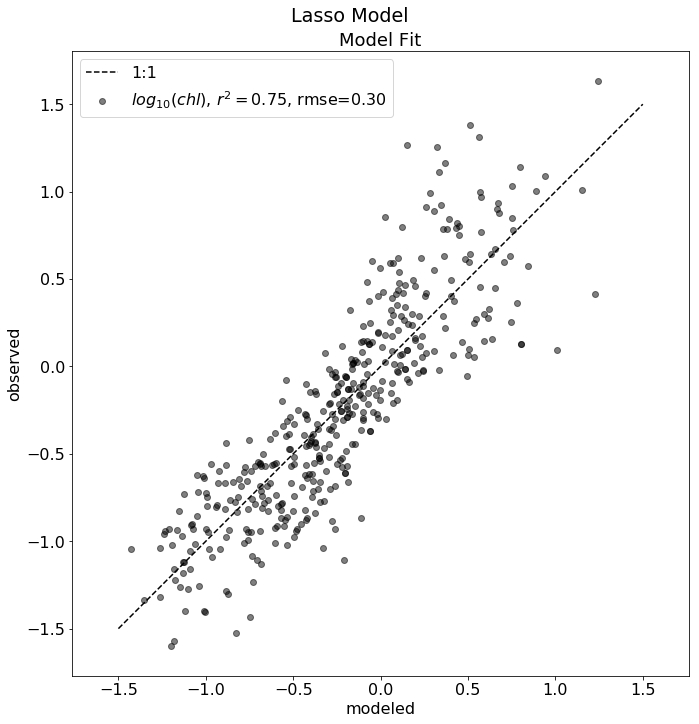

In [13]:
ax0 = m_lasso_.plot_model_fits(y_obs=y, title='Lasso Model')

#### <u>2. with missing data imputation</u> 

In [14]:
m_lasso_na_ = PyMCModel(lasso_regression, X_s_na, y_na, model_name='lasso_w_imp')
m_lasso_na_.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:15<00:00, 648.69draws/s]


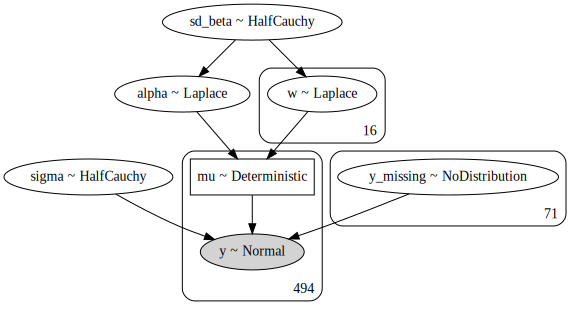

In [15]:
m_lasso_na_.show_model()

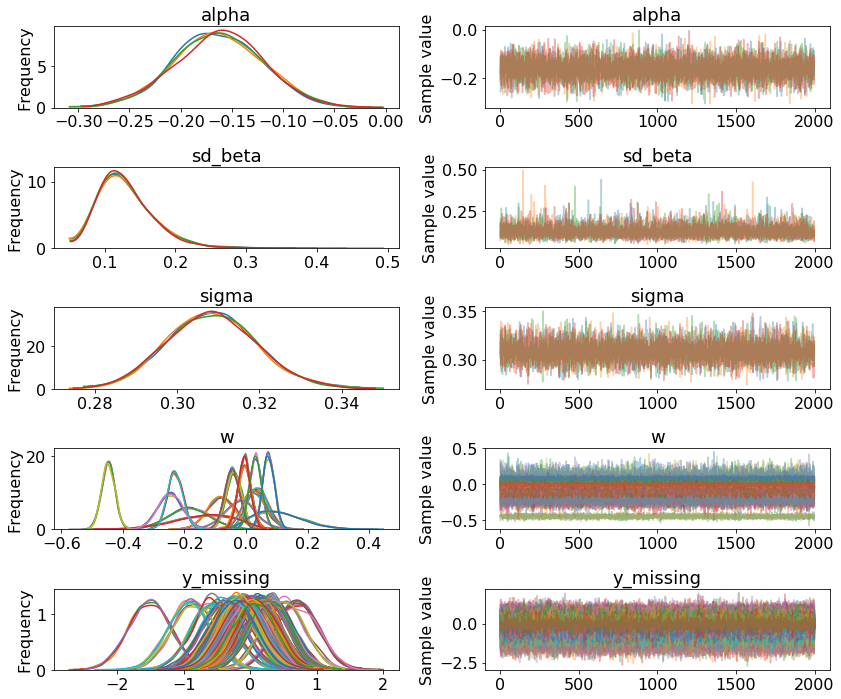

In [16]:
vars_na_ = vars_ + ['y_missing']
m_lasso_na_.evaluate_fit(vars_na_);

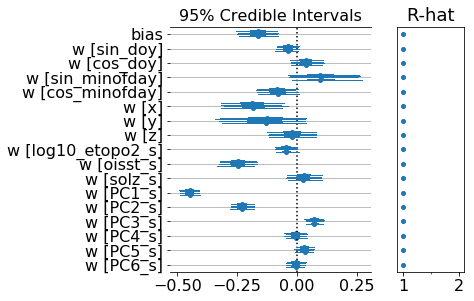

In [17]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_lasso_na_.show_forest(['alpha', 'w'], feat_labels=lbls_list);

100%|██████████| 2000/2000 [00:01<00:00, 1606.86it/s]


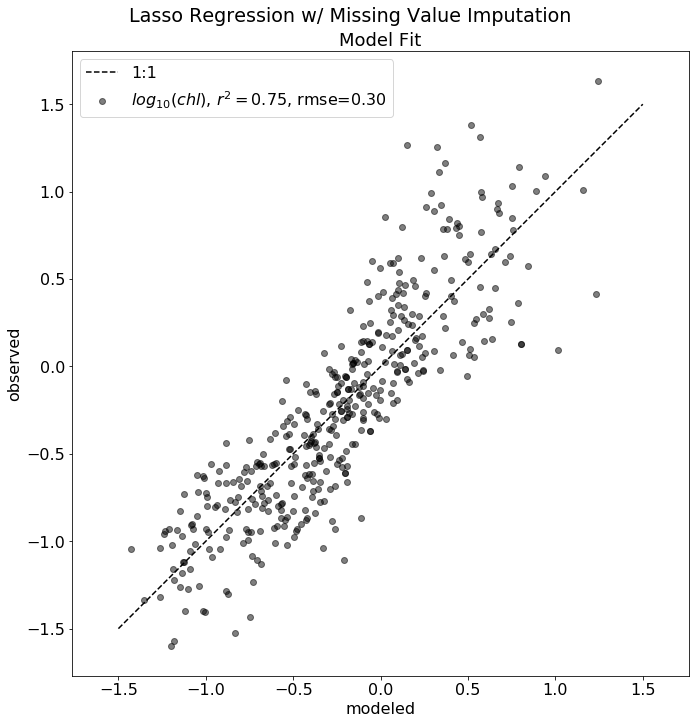

In [18]:
m_lasso_na_.plot_model_fits(y_obs=y_na,
                            title='Lasso Regression w/ Missing Value Imputation');

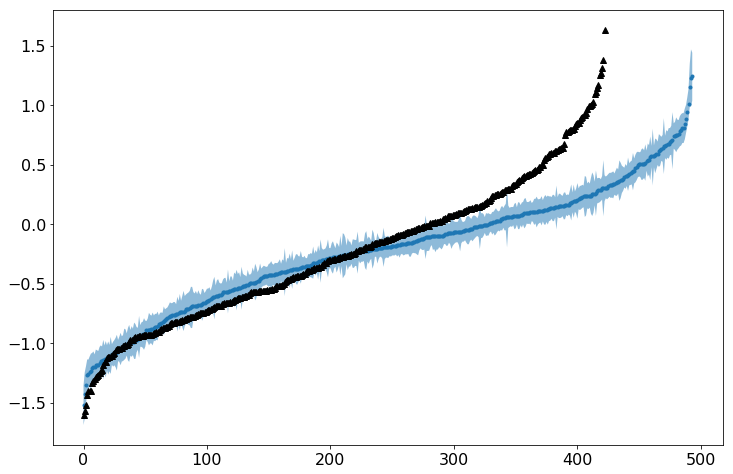

In [19]:
pred = m_lasso_na_.predict(X_s_na).T
pred_mean = pred.mean(axis=0)
hp = pm.hpd(pred)
ix = np.argsort(pred_mean)
xi = np.arange(pred_mean.size)
y_na_ma = np.ma.array(data=y_na, mask=np.isnan(y_na)).compressed()
y_namaix = np.argsort(y_na_ma)
xi_yna = np.arange(y_namaix.size)

pl.figure(figsize=(12, 8))
pl.plot(xi, pred_mean[ix], marker='.', ls='')
pl.plot()
pl.fill_between(xi, hp[ix,0], hp[ix, 1], alpha=0.5)
pl.plot(xi_yna, y_na_ma[y_namaix], marker='^', ls='', color='k')

<u>Discover significant_features</u>

In [20]:
lasso_sub_feats = subset_significant_feature(m_lasso_na_.trace_,
                                             lbls_X_s, beg_feat=feat_beg)

In [21]:
lasso_sub_feats

['x', 'oisst_s', 'PC1_s', 'PC2_s', 'PC3_s']

#### <u>3. With missing value imputation and subsetting of "significant features</u>

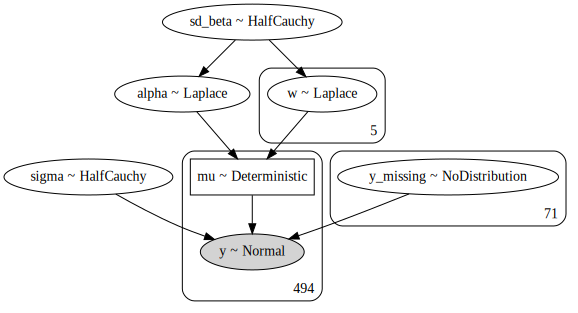

In [22]:
X_na_sub = ds.loc[:, lasso_sub_feats].values
mlasso_sub = PyMCModel(lasso_regression, X_na_sub, y_na,
                       model_name='lasso_regr_sub_w_imp')
mlasso_sub.show_model()

In [23]:
mlasso_sub.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1733.78draws/s]


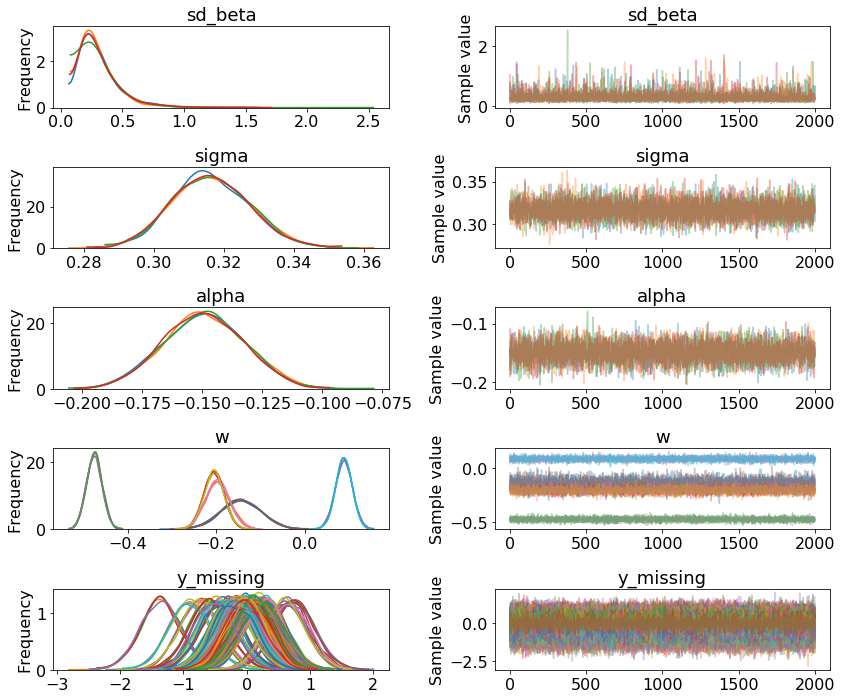

In [24]:
vars_ = ['sd_beta', 'sigma', 'alpha', 'w', 'y_missing']
mlasso_sub.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1621.06it/s]


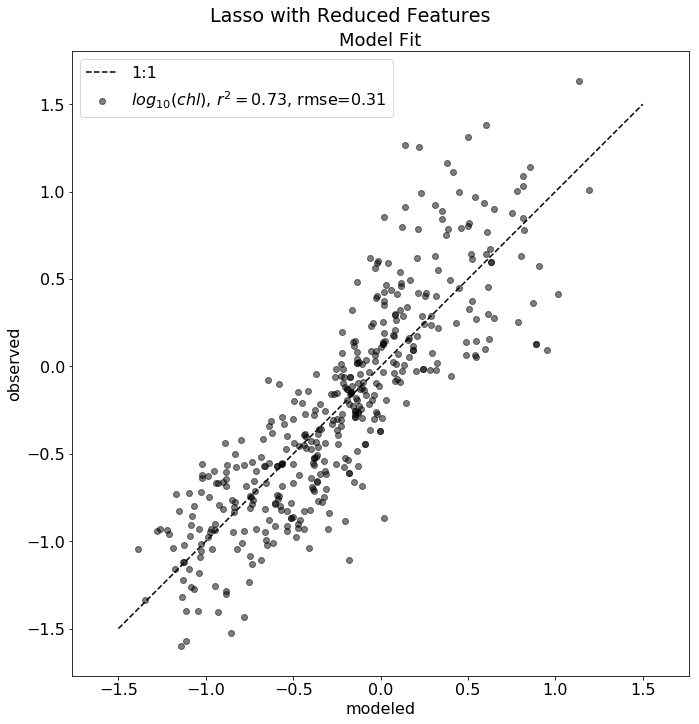

In [25]:
mlasso_sub.plot_model_fits(y_na, title='Lasso with Reduced Features');

### Modeling with Maximum Feature Interactions

#### <u>1. No missing value imputation</u>

In [26]:
mp_lasso = PyMCModel(lasso_regression, Xp_s, y, model_name='lasso_w_max_interactions')

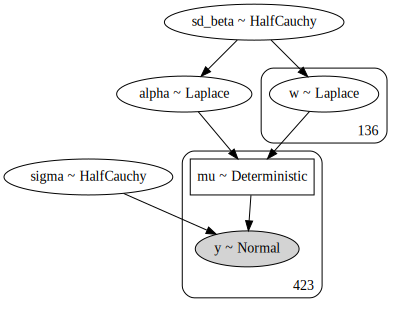

In [27]:
mp_lasso.show_model()

In [28]:
mp_lasso.fit_ADVI()

Average Loss = 114.74: 100%|██████████| 100000/100000 [00:55<00:00, 1792.17it/s]
Finished [100%]: Average Loss = 114.75


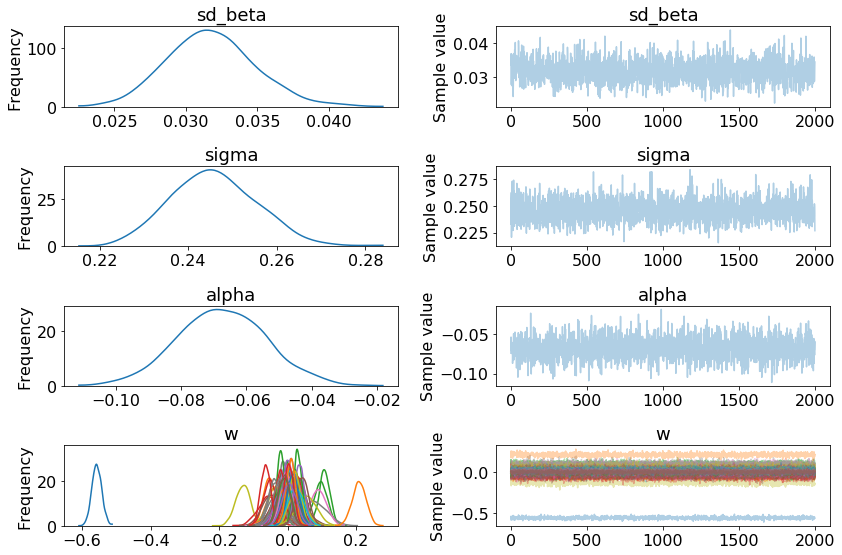

In [29]:
vars_ =['sd_beta', 'sigma', 'alpha', 'w']
mp_lasso.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1443.53it/s]


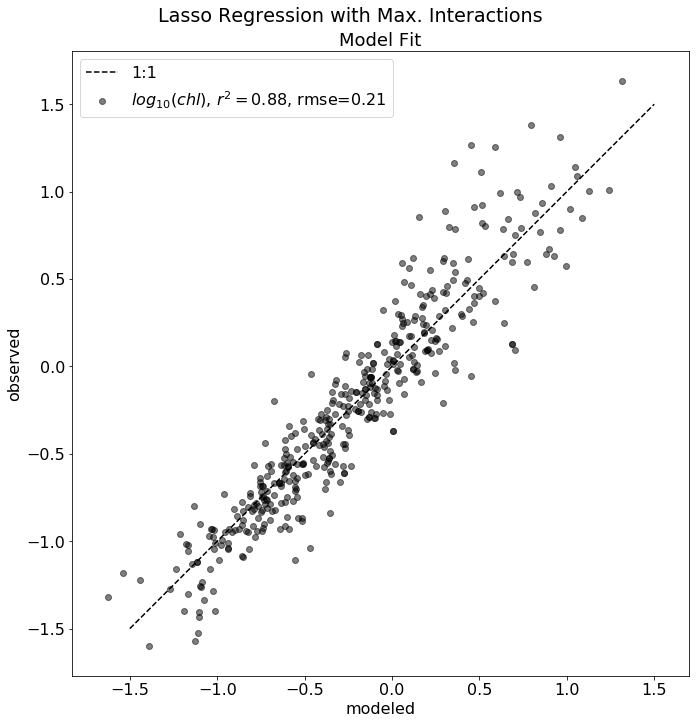

In [30]:
mp_lasso.plot_model_fits(y, title='Lasso Regression with Max. Interactions');

#### <u>2. with missing data imputation</u>

In [31]:
mp_lasso_na = PyMCModel(lasso_regression, Xp_s_na, y_na, 
                        model_name='lasso_w_max_inter_&_imp')

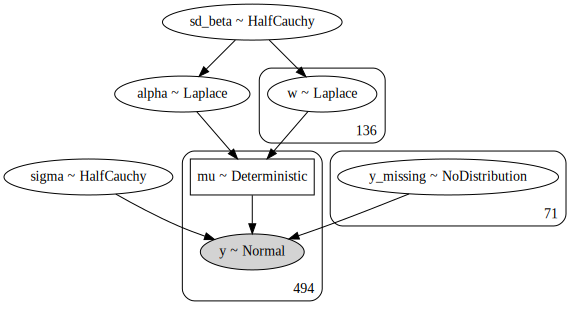

In [32]:
mp_lasso_na.show_model()

In [33]:
mp_lasso_na.fit_ADVI()

Average Loss = 122.35: 100%|██████████| 100000/100000 [01:01<00:00, 1619.39it/s]
Finished [100%]: Average Loss = 122.28


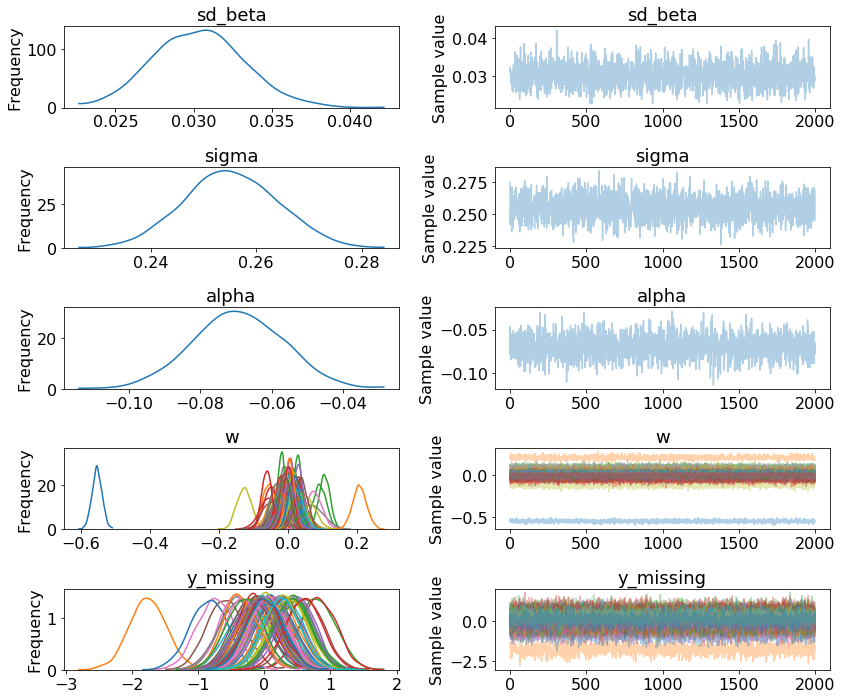

In [34]:
vars_ = vars_ =['sd_beta', 'sigma', 'alpha', 'w', 'y_missing']
mp_lasso_na.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1364.06it/s]


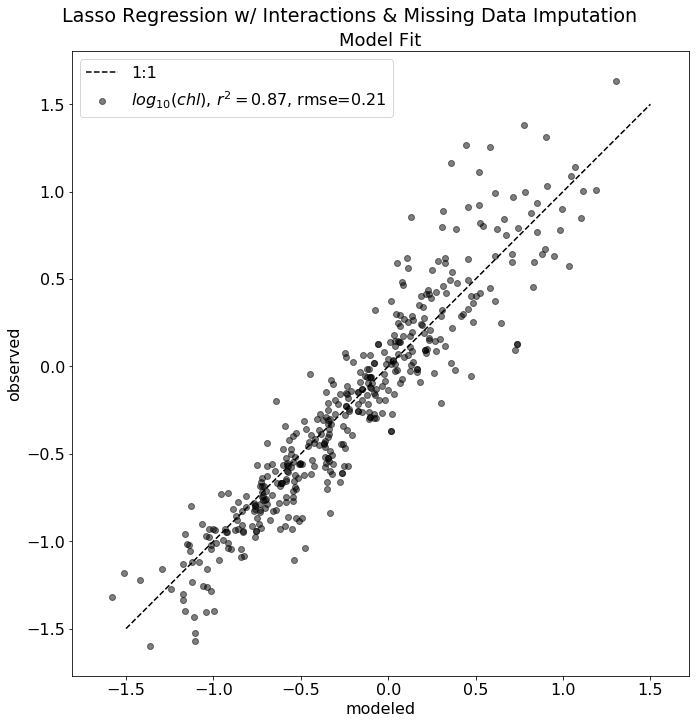

In [35]:
mp_lasso_na.plot_model_fits(y_na,
                            title='Lasso Regression w/ Interactions & Missing Data Imputation'
                           );

#### <u>3. Subset significant features </u>

In [36]:
lasso_inter_sub_feats = subset_significant_feature(mp_lasso_na.trace_, 
                                                    lbls_Xp_s, feat_beg, alpha=0.1)

In [37]:
lasso_inter_sub_feats

['oisst_s',
 'PC1_s',
 'PC2_s',
 'PC3_s',
 'PC4_s',
 'sin_doy log10_etopo2_s',
 'sin_doy oisst_s',
 'cos_doy PC5_s',
 'sin_minofday y',
 'x PC3_s',
 'y PC2_s',
 'log10_etopo2_s PC1_s',
 'log10_etopo2_s PC2_s',
 'log10_etopo2_s PC4_s',
 'log10_etopo2_s PC6_s',
 'oisst_s solz_s',
 'PC1_s PC2_s',
 'PC1_s PC3_s',
 'PC1_s PC4_s',
 'PC1_s PC5_s',
 'PC1_s PC6_s']

In [38]:
Xp_s_na_sub = dps.loc[:, lasso_inter_sub_feats].values
mp_lasso_na_sub = PyMCModel(lasso_regression, Xp_s_na_sub, y_na, 
                            model_name='lasso_regr_w_sub_inter_&_imp.')

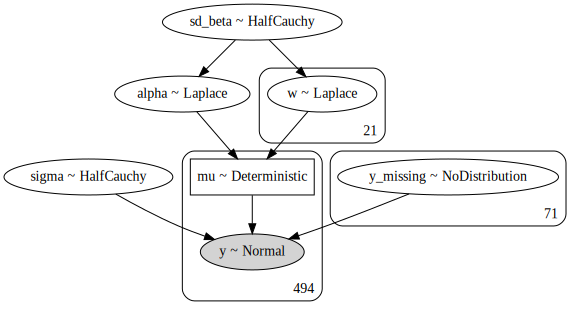

In [39]:
mp_lasso_na_sub.show_model()

In [40]:
mp_lasso_na_sub.fit_ADVI()

Average Loss = 69.33: 100%|██████████| 100000/100000 [00:48<00:00, 2078.85it/s]
Finished [100%]: Average Loss = 69.321


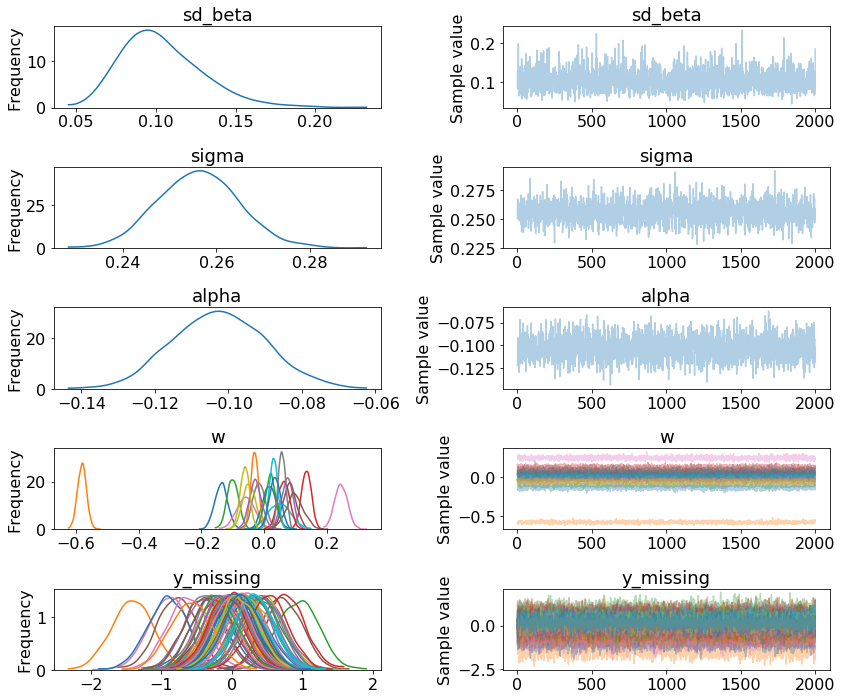

In [41]:
vars_ = ['sd_beta', 'sigma', 'alpha', 'w', 'y_missing']
mp_lasso_na_sub.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1599.62it/s]


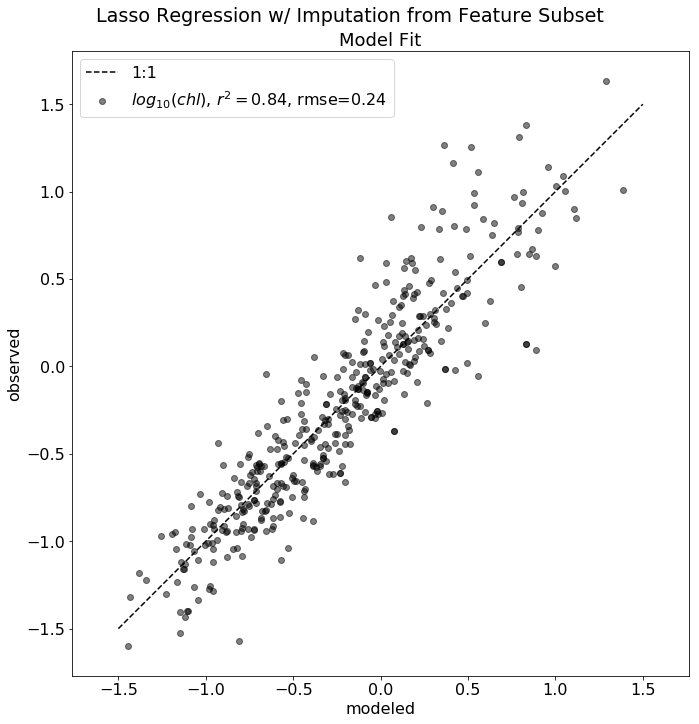

In [42]:
mp_lasso_na_sub.plot_model_fits(y_na,
                                title='Lasso Regression w/ Imputation from Feature Subset'
                               );

### Regression with PCA interactions
#### <u> 1. No imputation</u>

In [43]:
mpcap_lasso = PyMCModel(lasso_regression, Xpcap_s, y,
                        model_name='lasso_regr_w_pca_inter.')

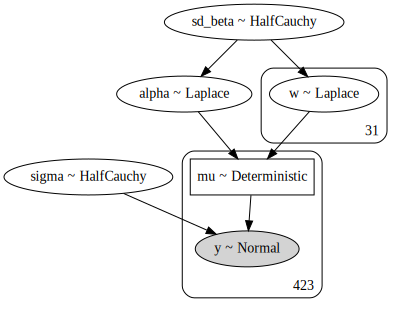

In [44]:
mpcap_lasso.show_model()

In [45]:
mpcap_lasso.fit_ADVI()

Average Loss = 77.072: 100%|██████████| 100000/100000 [00:43<00:00, 2286.59it/s]
Finished [100%]: Average Loss = 77.083


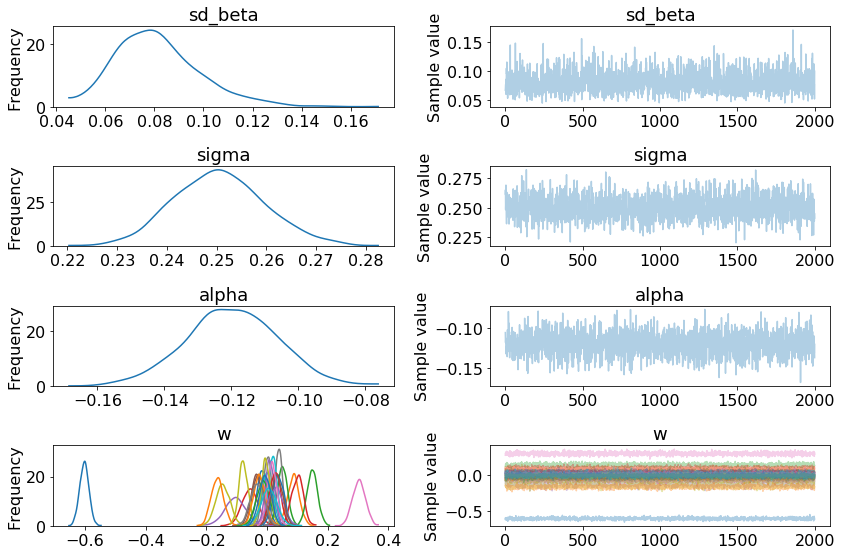

In [48]:
vars_ = ['sd_beta', 'sigma', 'alpha', 'w']
mpcap_lasso.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1462.79it/s]


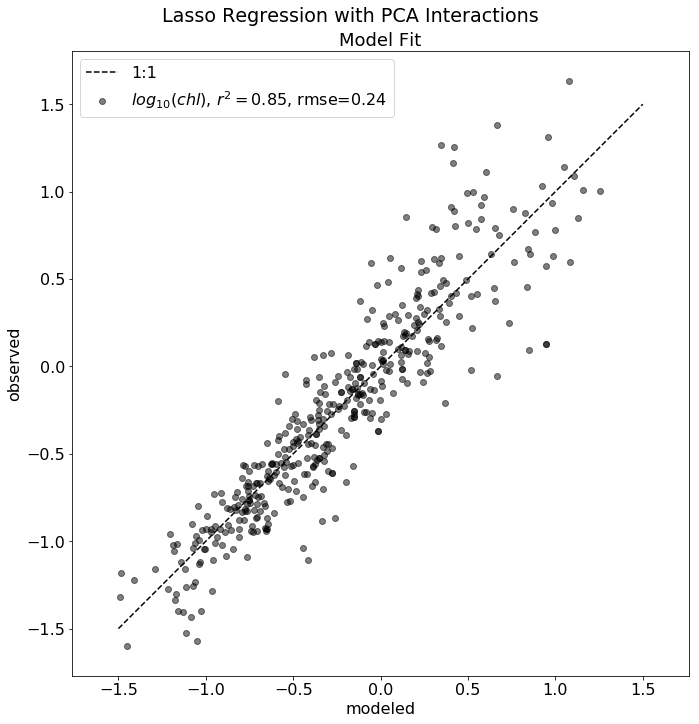

In [50]:
mpcap_lasso.plot_model_fits(y, title = 'Lasso Regression with PCA Interactions');

#### <u>2. with missing data imputation</u>

In [52]:
mpcap_lasso_na = PyMCModel(lasso_regression, Xpcap_s_na, y_na,
                          model_name='lasso_regr_w_pca_inter_&_imp.')

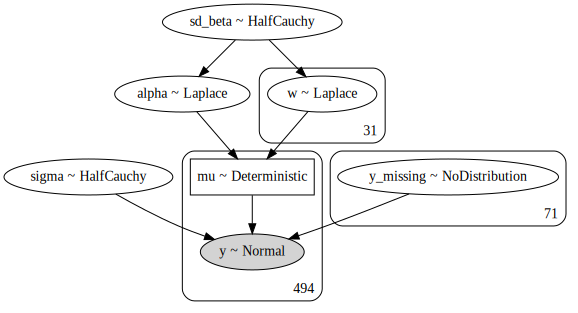

In [53]:
mpcap_lasso_na.show_model()

In [54]:
mpcap_lasso_na.fit_ADVI()

Average Loss = 80.352: 100%|██████████| 100000/100000 [00:49<00:00, 2009.98it/s]
Finished [100%]: Average Loss = 80.334


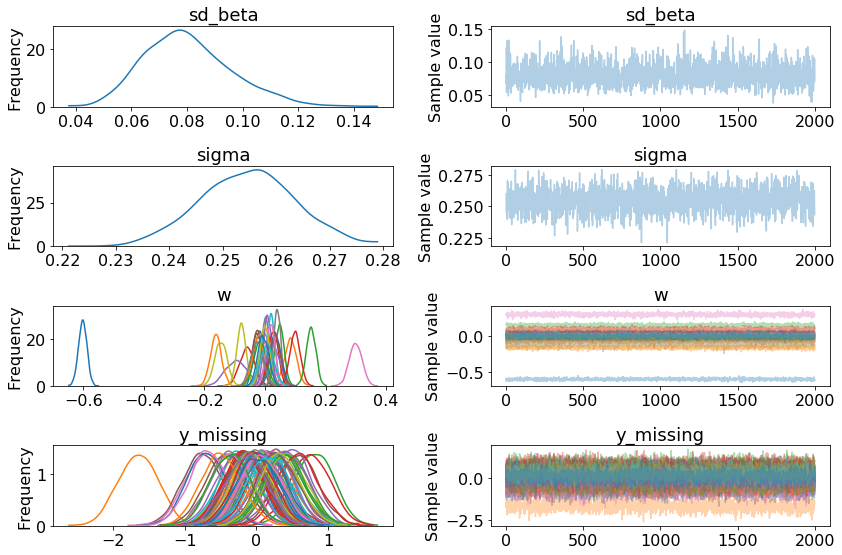

In [56]:
vars_ = ['sd_beta', 'sigma', 'w', 'y_missing']
mpcap_lasso_na.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1435.22it/s]


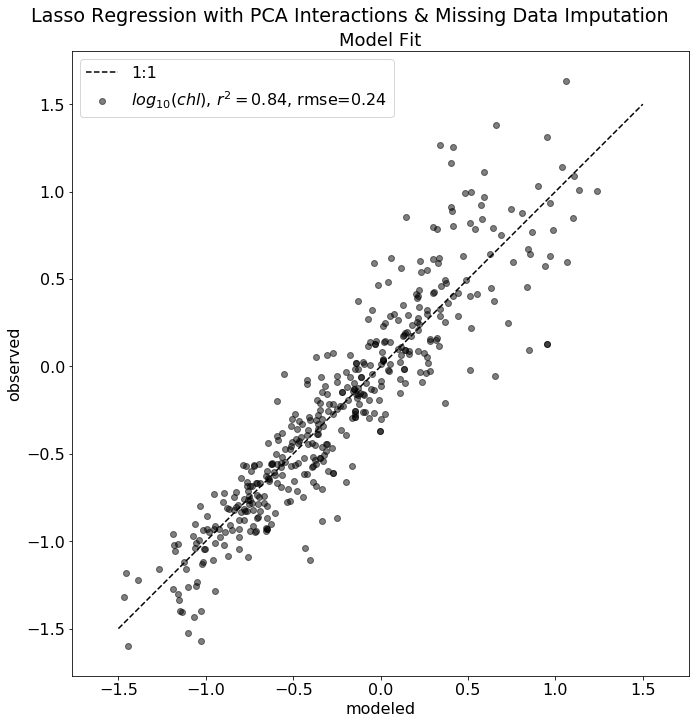

In [57]:
mpcap_lasso_na.plot_model_fits(y_na, title='Lasso Regression with PCA Interactions & Missing Data Imputation');

In [60]:
pca_sub_lbls = subset_significant_feature(mpcap_lasso_na.trace_,
                                          lbls_Xpcap_s, beg_feat=feat_beg,
                                         alpha=0.1)

In [67]:
pca_sub_lbls = ['sin_doy'] + pca_sub_lbls

In [69]:
Xpcap_na_sub = dpcapoly_s.loc[:, pca_sub_lbls].values

In [70]:
mpcap_lasso_sub = PyMCModel(lasso_regression, Xpcap_na_sub, y_na,
                            model_name='lasso_w_pca_inter_sub_&_imp..')

In [71]:
mpcap_lasso_sub.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:08<00:00, 1200.54draws/s]


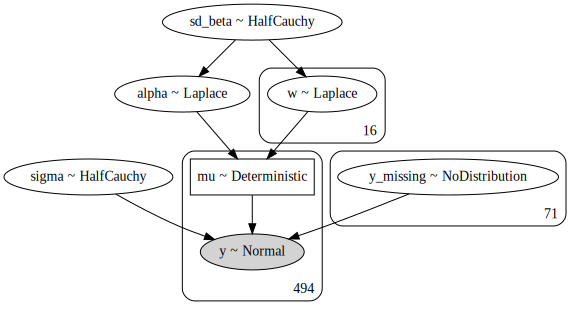

In [72]:
mpcap_lasso_sub.show_model()

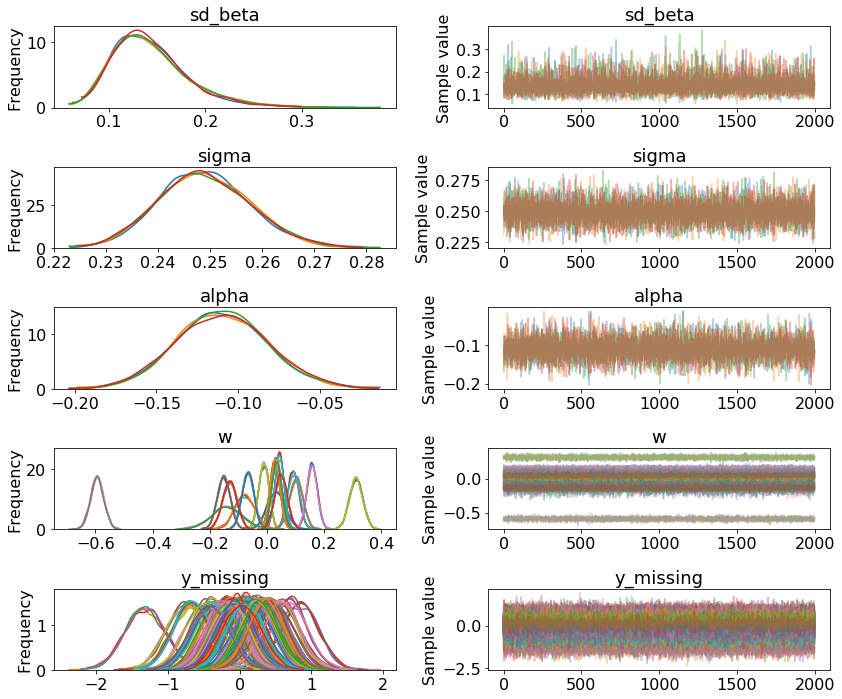

In [73]:
vars_ = ['sd_beta', 'sigma', 'alpha', 'w', 'y_missing']
mpcap_lasso_sub.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1580.63it/s]


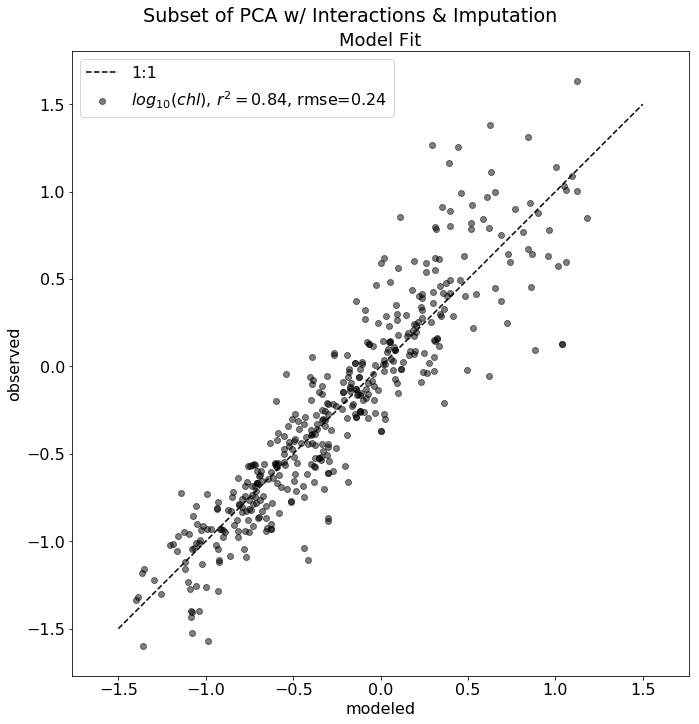

In [74]:
mpcap_lasso_sub.plot_model_fits(y_na, title='Subset of PCA w/ Interactions & Imputation');

In [77]:
m_lasso_na_.model

'lasso_regr_sub_w_imp'

In [79]:
mod_dict = {m_lasso_.model: m_lasso_.trace_,
            m_lasso_na_.model: m_lasso_na_.trace_,
            mlasso_sub.model: mlasso_sub.trace_,
            mp_lasso.model: mp_lasso.trace_,
            mp_lasso_na.model: mp_lasso_na.trace_,
            mp_lasso_na_sub.model: mp_lasso_na_sub.trace_,
            mpcap_lasso.model: mpcap_lasso.trace_,
            mpcap_lasso_na.model: mpcap_lasso_na.trace_,
            mpcap_lasso_sub.model: mpcap_lasso_sub.trace_,
           }
pm.compare(mod_dict)

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
lasso_w_pca_inter_sub_&_imp..,44.03,19.97,0,0.67,41.69,0,1
lasso_regr_w_pca_inter_&_imp.,59.94,32.29,15.91,0,38.79,8.43,1
lasso_regr_w_sub_inter_&_imp.,61.79,26.31,17.76,0.33,35.43,19.09,1
lasso_regr_w_pca_inter.,72.12,39.54,28.09,0,40.52,8.7,1
lasso_w_max_inter_&_imp,125.46,86.21,81.44,0,35.75,19.72,1
lasso_w_max_interactions,156.99,110.56,112.97,0,40.63,24.17,1
lasso_no_imp,223.71,18.99,179.68,0,33.58,26.11,1
lasso_w_imp,223.91,19.03,179.88,0,33.5,26.13,1
lasso_regr_sub_w_imp,233.25,7.94,189.22,0,32.37,25.09,0


In [80]:
pm.compare(mod_dict, ic='LOO')

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. T

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
lasso_w_pca_inter_sub_&_imp..,44.68,20.3,0,0.68,41.72,0,1
lasso_regr_w_pca_inter_&_imp.,63.28,33.96,18.6,0,39.07,8.78,1
lasso_regr_w_sub_inter_&_imp.,66.57,28.7,21.88,0.32,35.85,19.67,1
lasso_regr_w_pca_inter.,78.77,42.87,34.09,0,41.15,9.68,1
lasso_w_max_inter_&_imp,169.76,108.36,125.08,0,43.13,29.01,1
lasso_no_imp,223.93,19.1,179.25,0,33.61,26.18,0
lasso_w_imp,224.1,19.13,179.42,0,33.53,26.19,0
lasso_w_max_interactions,226.32,145.22,181.63,0,52.52,38.82,1
lasso_regr_sub_w_imp,233.26,7.94,188.57,0,32.37,25.14,0


In [81]:
models_dict = {m_lasso_.model.name: m_lasso_,
               m_lasso_na_.model.name: m_lasso_na_,
               mlasso_sub.model.name: mlasso_sub,
               mp_lasso.model.name: mp_lasso,
               mp_lasso_na.model.name: mp_lasso_na,
               mp_lasso_na_sub.model.name: mp_lasso_na_sub,
               mpcap_lasso.model.name: mpcap_lasso,
               mpcap_lasso_na.model.name: mpcap_lasso_na,
               mpcap_lasso_sub.model.name: mpcap_lasso_sub}
with open('./pickleJar/Models/pooled_models.pkl', 'wb') as f:
    pickle.dump(models_dict, f, protocol=pickle.HIGHEST_PROTOCOL)